<a href="https://colab.research.google.com/github/njucs/notebook/blob/master/LMM_Design_Patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

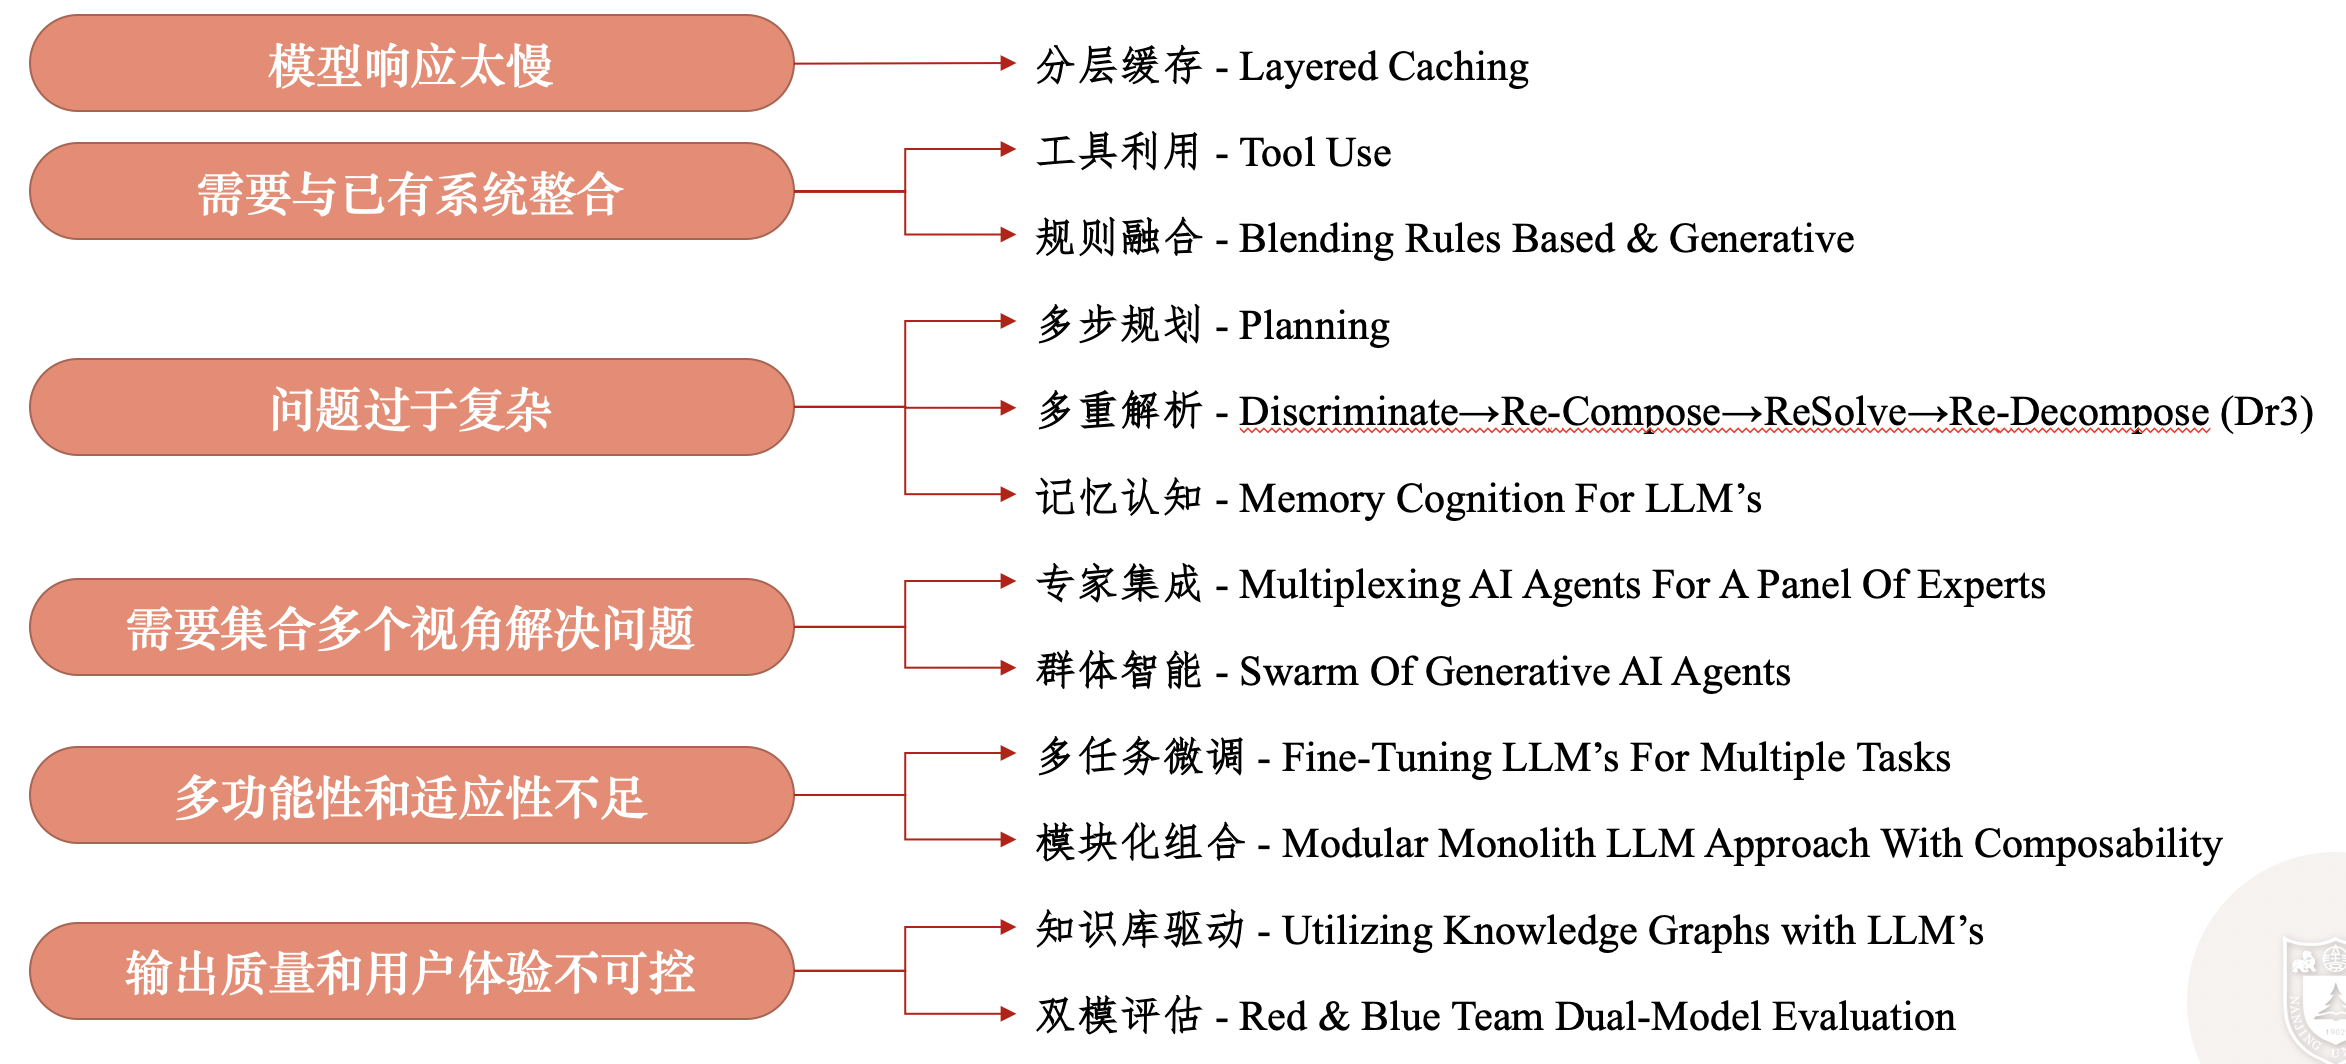

### 分层缓存 Layered Caching
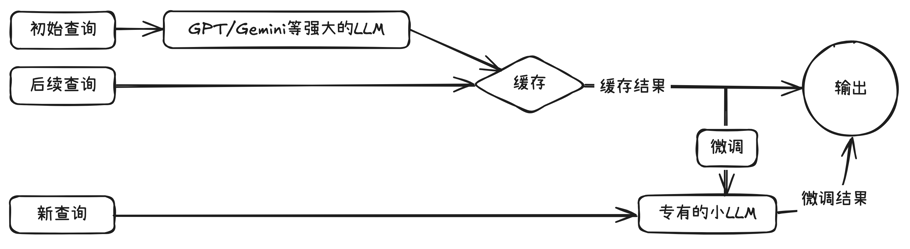

In [1]:
# -*- coding: utf-8 -*-
"""
# LLM 查询处理流程演示

本 Jupyter Notebook 演示了一个使用大型语言模型（LLM）进行查询处理的系统流程。
该流程对应了图片中的结构，模拟了初始查询、缓存、后续查询、新查询、大型LLM、
小型LLM微调以及最终输出等环节。
"""

import random
from typing import Dict, Callable

# --- 1. 模拟查询 ---
def generate_query(query_type: str):
    """
    生成模拟查询
    Args:
        query_type: 查询类型，如 "initial", "follow-up", "new"
    Returns:
        查询文本
    """
    if query_type == "initial":
        return f"Initial Query {random.randint(1, 100)}"
    elif query_type == "follow-up":
        return f"Follow-up Query {random.randint(1, 100)}"
    elif query_type == "new":
        return f"New Query {random.randint(1, 100)}"
    else:
        return "Invalid Query Type"

# --- 2. 模拟大型LLM ---
def mock_large_llm(query: str):
    """
    模拟大型LLM的处理
    Args:
        query: 查询文本
    Returns:
        LLM 的模拟响应
    """
    return f"Large LLM Response for: {query}"

# --- 3. 模拟小型LLM ---
class SmallLLM:
    def __init__(self, name: str, training_data: dict = None):
        """
        初始化小型LLM
        Args:
            name: 小型LLM名称
            training_data: 用于微调的训练数据，格式为 {query: response}
        """
        self.name = name
        self.training_data = training_data if training_data else {} # 如果没有传递，则初始化为空字典

    def process_query(self, query: str):
        """
        处理查询
        Args:
            query: 查询文本
        Returns:
            小型LLM的模拟响应
        """
        # 模拟微调效果：如果查询在训练数据中，直接返回训练数据中的响应，否则返回默认响应
        if query in self.training_data:
             return f"Fine-tuned Small LLM Response from training data for: {query}, result: {self.training_data[query]}"
        else:
            return f"Fine-tuned Small LLM Response for: {query}"


    def fine_tune(self, query, response):
        """
         使用新的数据对小型LLM进行微调
        Args:
            query: 查询文本
            response: 对应的响应文本
        """
        self.training_data[query] = response
        print(f"Small LLM '{self.name}' has been fine-tuned with query: '{query}' and response: '{response}' ")

# --- 4. 模拟缓存 ---
class QueryCache:
    def __init__(self):
        """
        初始化查询缓存
        """
        self.cache = {}

    def check_cache(self, query: str):
        """
        检查缓存中是否存在查询
        Args:
            query: 查询文本
        Returns:
            缓存结果，如果存在，否则返回 None
        """
        return self.cache.get(query)

    def add_to_cache(self, query: str, response: str):
        """
        将查询和响应添加到缓存
        Args:
             query: 查询文本
             response: LLM 的响应文本
        """
        self.cache[query] = response
        print(f"Query '{query}' added to the cache.")

# --- 5. 系统流程函数 ---
def process_query_system(query_type: str, large_llm_func: Callable = mock_large_llm, cache: QueryCache = None, small_llm: SmallLLM = None):
    """
    处理不同类型的查询，并输出结果
    Args:
        query_type: 查询类型，如 "initial", "follow-up", "new"
        large_llm_func: 用于处理查询的大型LLM函数
        cache: 用于查询缓存
        small_llm:  用于处理新查询的小型LLM实例
    Returns:
        查询处理结果
    """
    query = generate_query(query_type)
    print(f"\nReceived {query_type} query: '{query}'")
    if query_type == "initial":
        llm_response = large_llm_func(query)
        if cache:
            cache.add_to_cache(query, llm_response)
            return llm_response
        else:
            return llm_response

    elif query_type == "follow-up":
        if cache:
            cached_response = cache.check_cache(query)
            if cached_response:
                print("  Cache hit.")
                return cached_response
            else:
                print("  Cache miss, using Large LLM")
                llm_response = large_llm_func(query)
                if cache:
                    cache.add_to_cache(query, llm_response)
                return llm_response
        else:
            llm_response = large_llm_func(query)
            return llm_response

    elif query_type == "new":
        if small_llm:
            print('  Using Small LLM')
            small_llm_response = small_llm.process_query(query)
            return small_llm_response
        else:
            print('  No Small LLM available, using large LLM')
            llm_response = large_llm_func(query)
            return llm_response


    else:
        return "Invalid query type"

# --- 6. 主函数 ---
if __name__ == '__main__':
    print("# Start Simulation #\n")
    # 初始化缓存和小型LLM
    cache = QueryCache()
    small_llm = SmallLLM('Specialized-LLM')

    # 初始查询
    initial_output = process_query_system("initial", cache=cache)
    print("  Output:", initial_output)

    # 后续查询，第一次缓存命中
    follow_up_output_1 = process_query_system("follow-up", cache=cache)
    print("  Output:", follow_up_output_1)

    # 后续查询，第二次，不在缓存中
    follow_up_output_2 = process_query_system("follow-up", cache=cache)
    print("  Output:", follow_up_output_2)

    # 新查询， 使用未微调的小型LLM
    new_output_1 = process_query_system("new", small_llm=small_llm)
    print("  Output:", new_output_1)

    # 模拟微调
    small_llm.fine_tune(generate_query('new'), 'Fine-tuned Response')

    # 新查询，使用微调后的小型LLM
    new_output_2 = process_query_system("new", small_llm=small_llm)
    print("  Output:", new_output_2)

# Start Simulation #


Received initial query: 'Initial Query 23'
Query 'Initial Query 23' added to the cache.
  Output: Large LLM Response for: Initial Query 23

Received follow-up query: 'Follow-up Query 25'
  Cache miss, using Large LLM
Query 'Follow-up Query 25' added to the cache.
  Output: Large LLM Response for: Follow-up Query 25

Received follow-up query: 'Follow-up Query 84'
  Cache miss, using Large LLM
Query 'Follow-up Query 84' added to the cache.
  Output: Large LLM Response for: Follow-up Query 84

Received new query: 'New Query 66'
  Using Small LLM
  Output: Fine-tuned Small LLM Response for: New Query 66
Small LLM 'Specialized-LLM' has been fine-tuned with query: 'New Query 47' and response: 'Fine-tuned Response' 

Received new query: 'New Query 19'
  Using Small LLM
  Output: Fine-tuned Small LLM Response for: New Query 19


### 工具利用 Tool Use

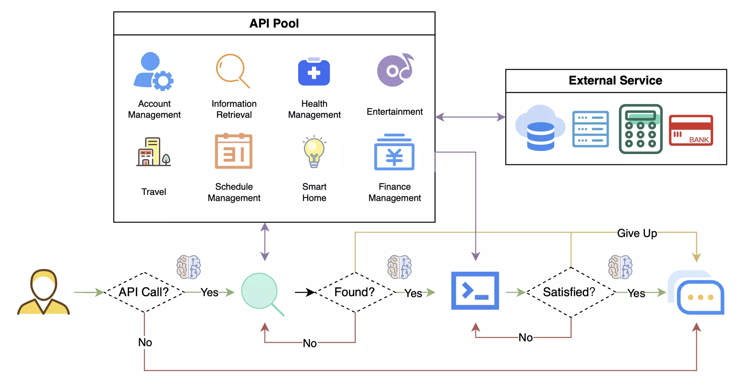

### 规则融合 Blending Rules Based & Generative

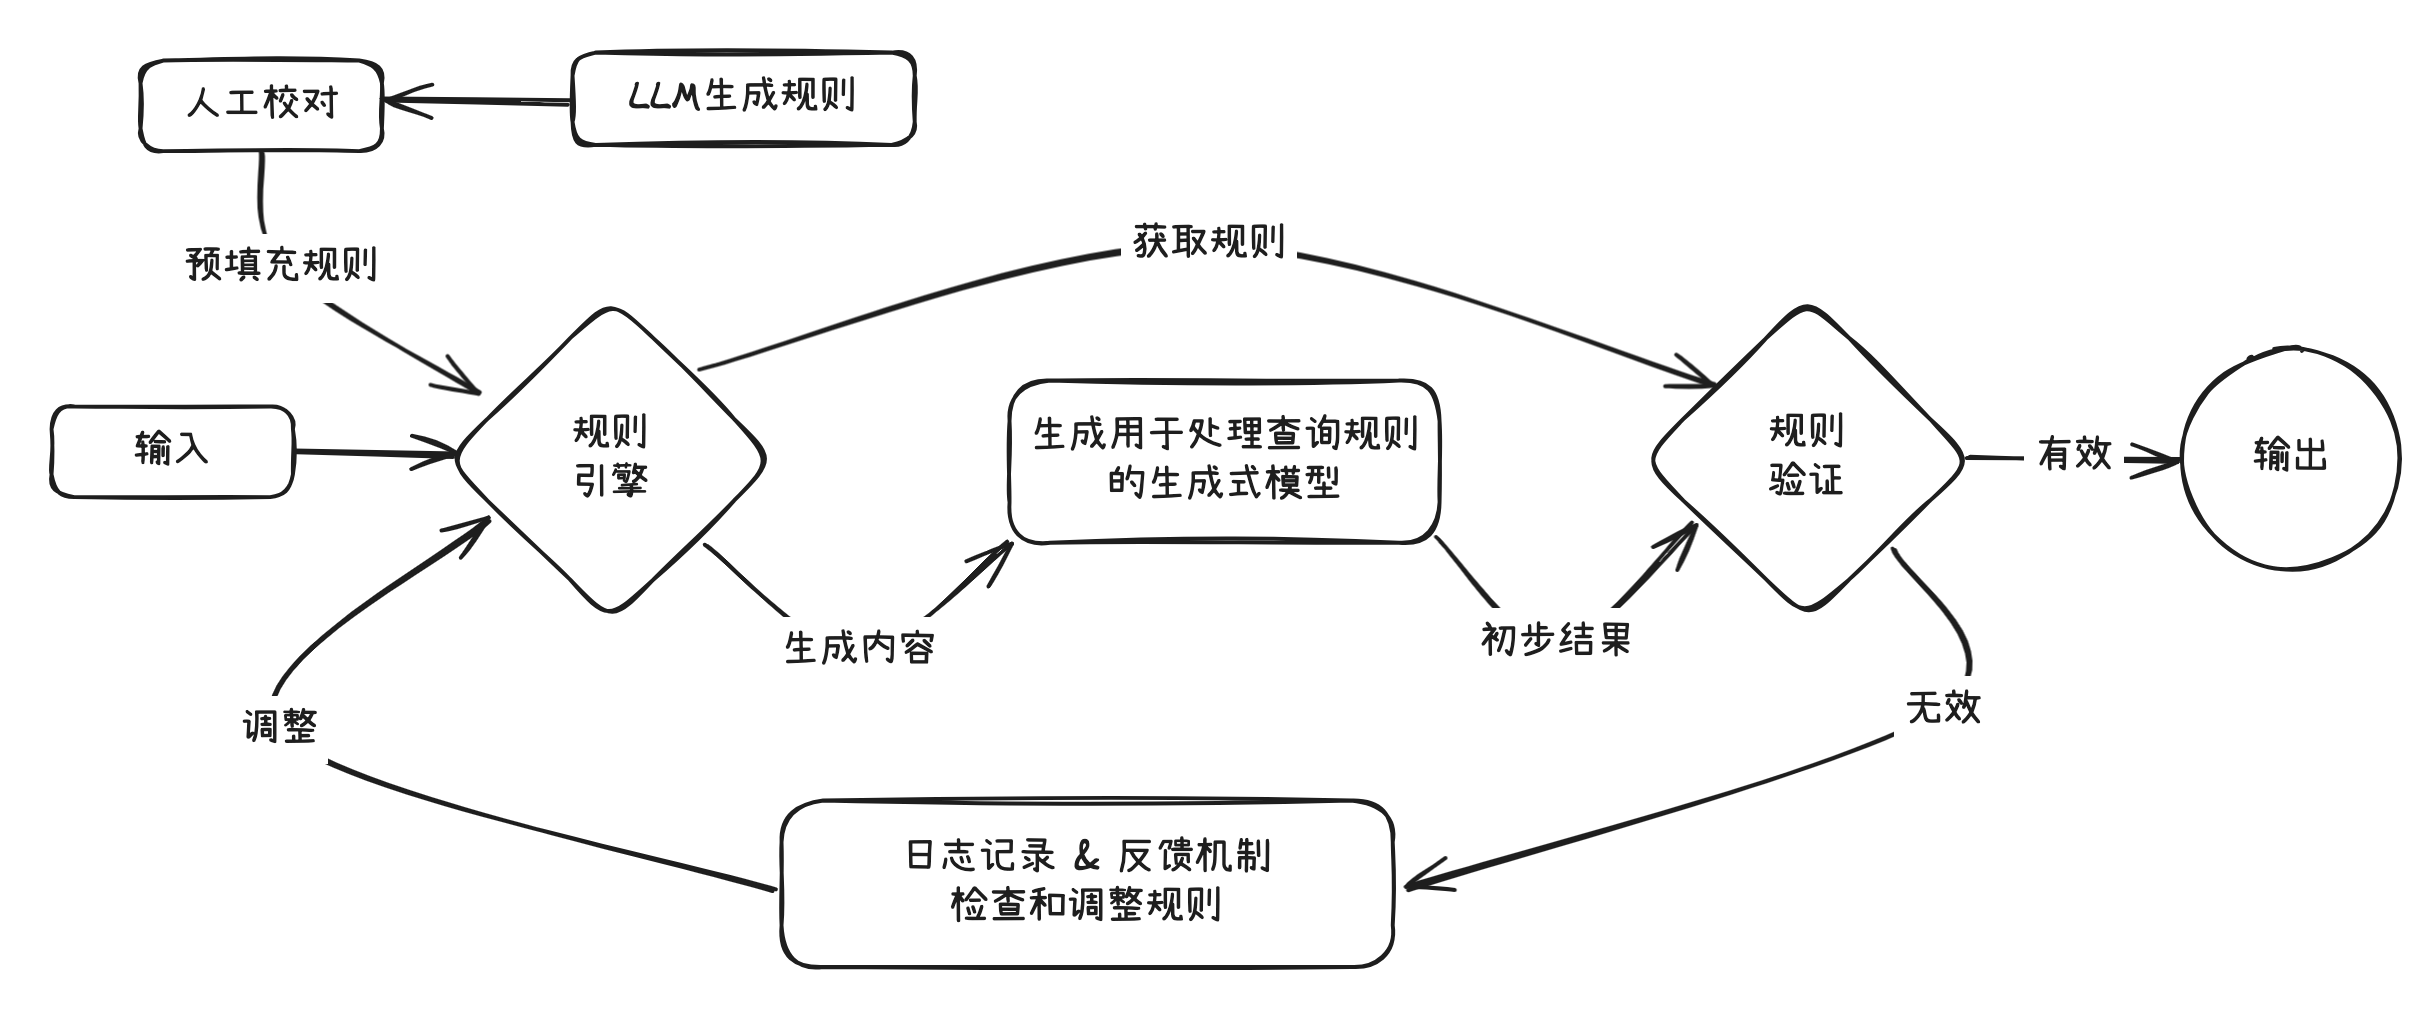

### 多步规划 Planning

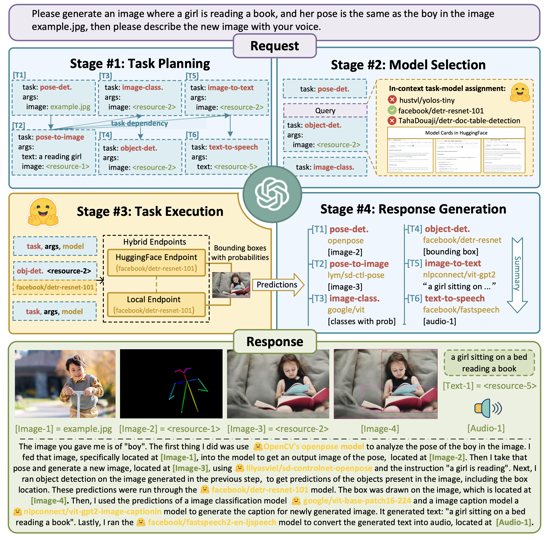

### 多重解析 - Discriminate→Re-Compose→ReSolve→Re-Decompose (Dr3)

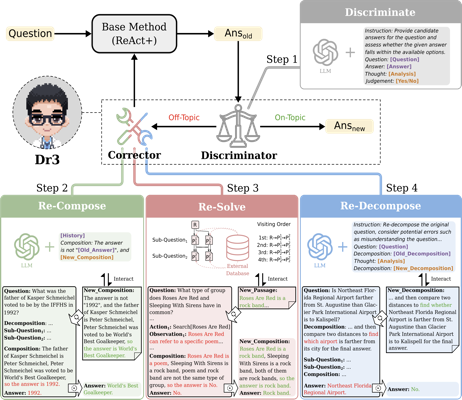

### 记忆认知 Memory Cognition For LLM’s

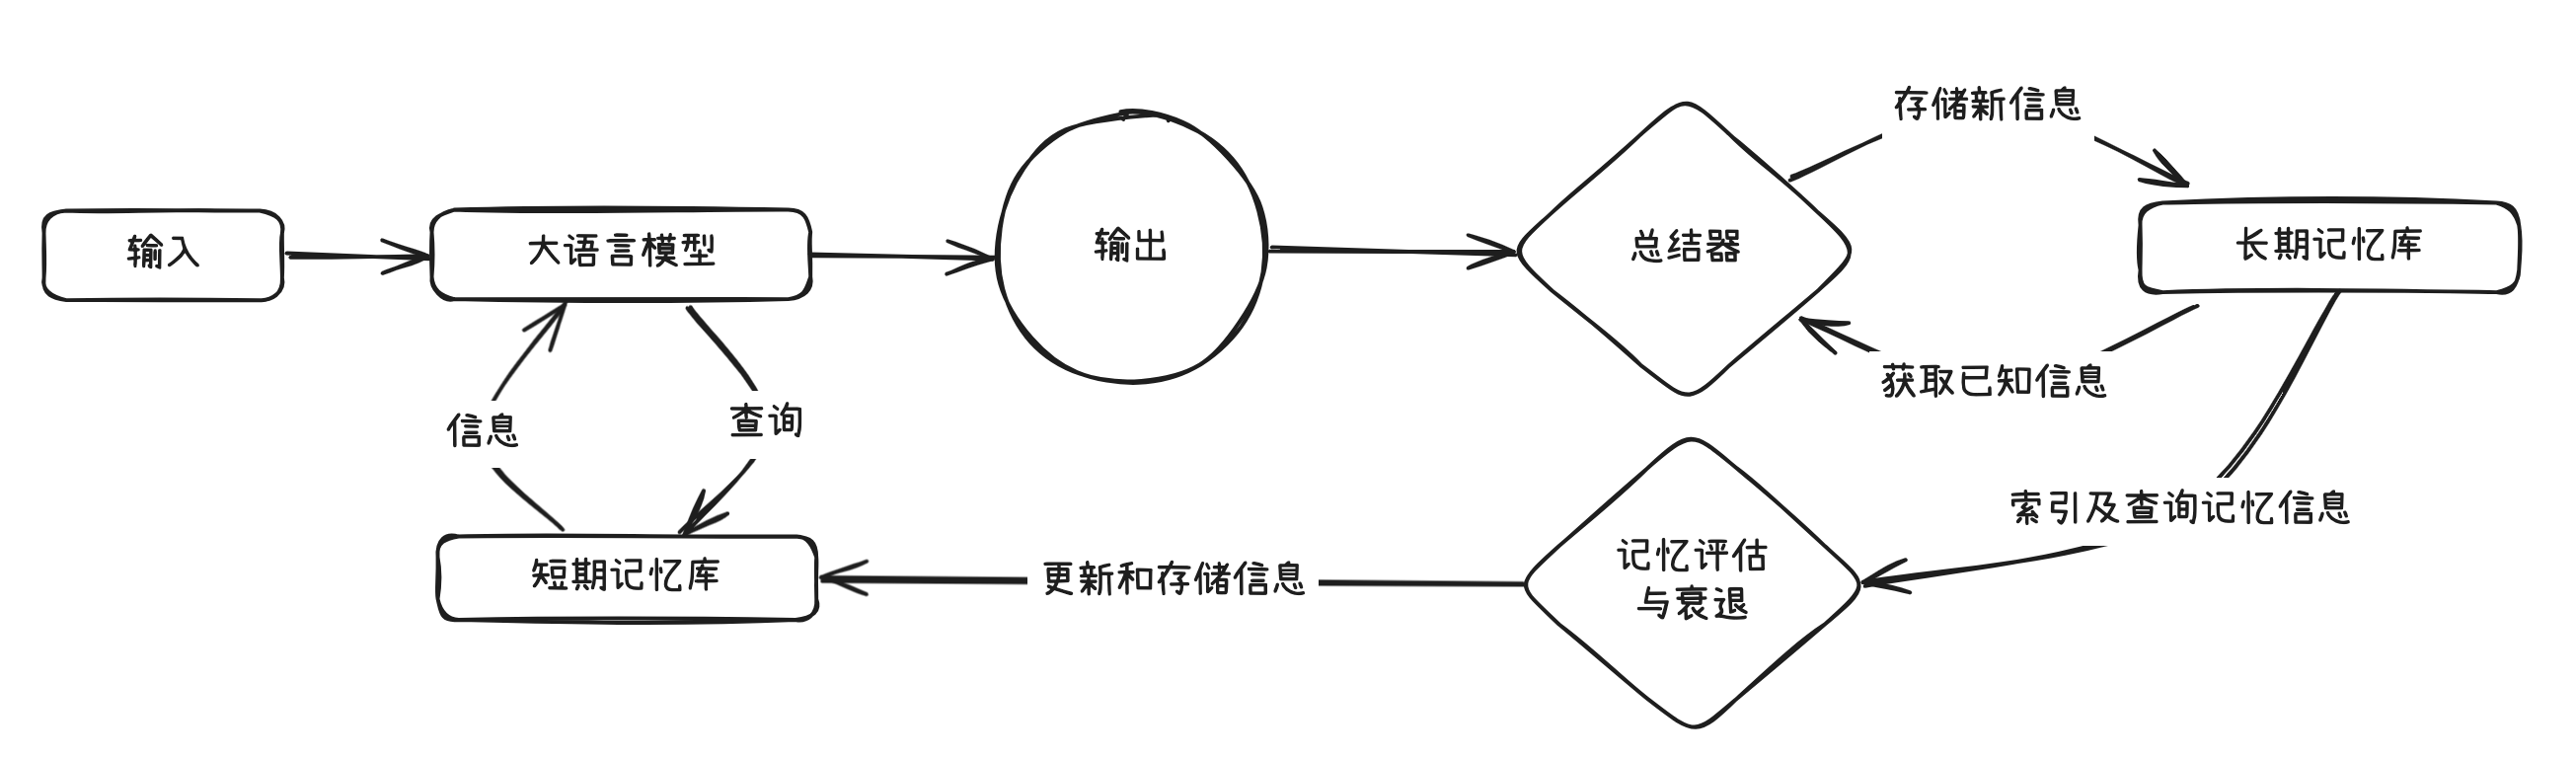

### 专家集成 Multiplexing AI Agents For A Panel Of Experts

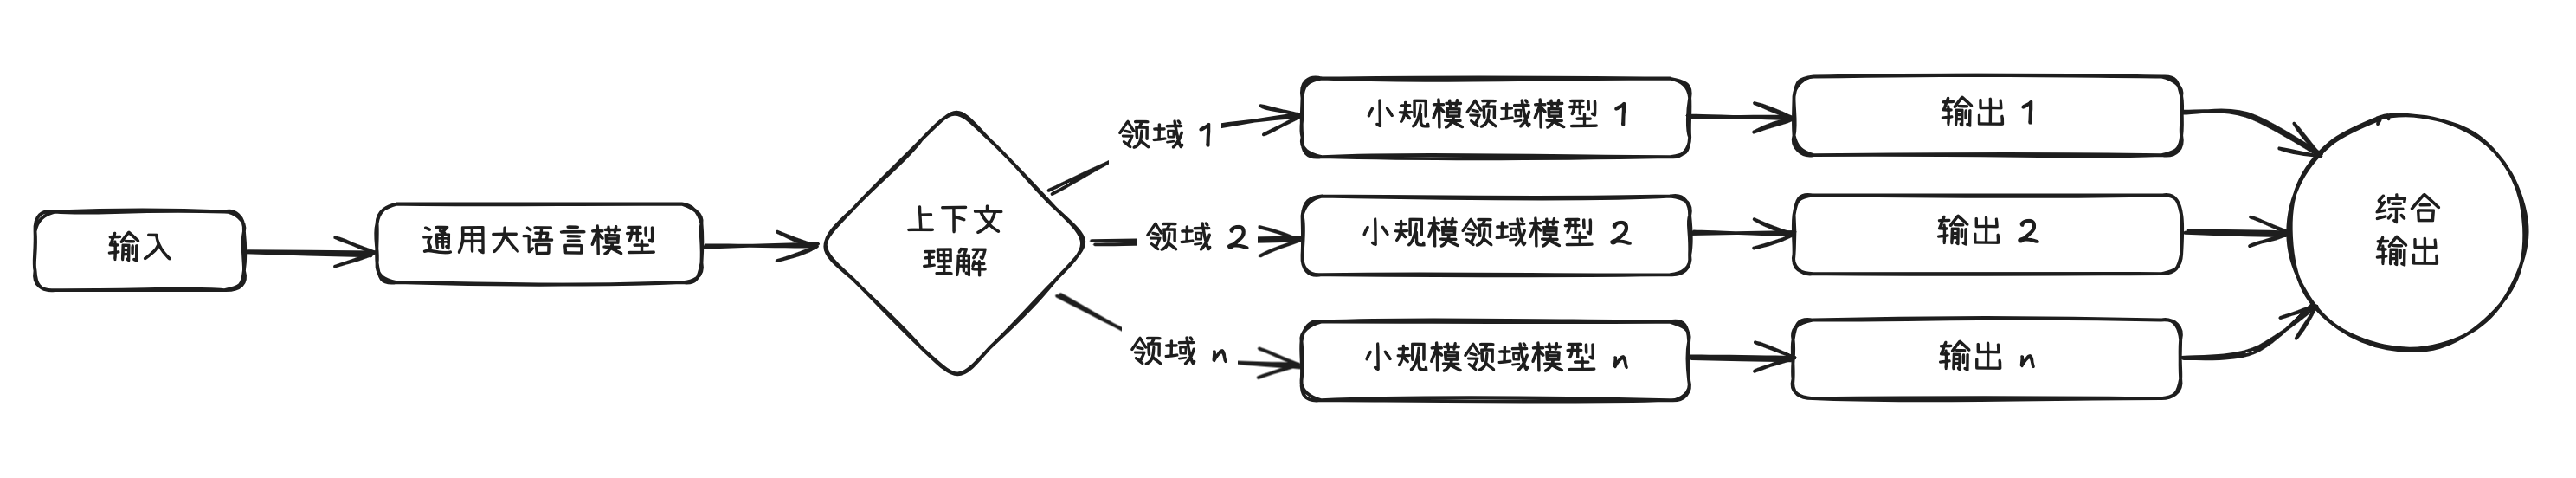

### 群体智能 Swarm Of Generative AI Agents

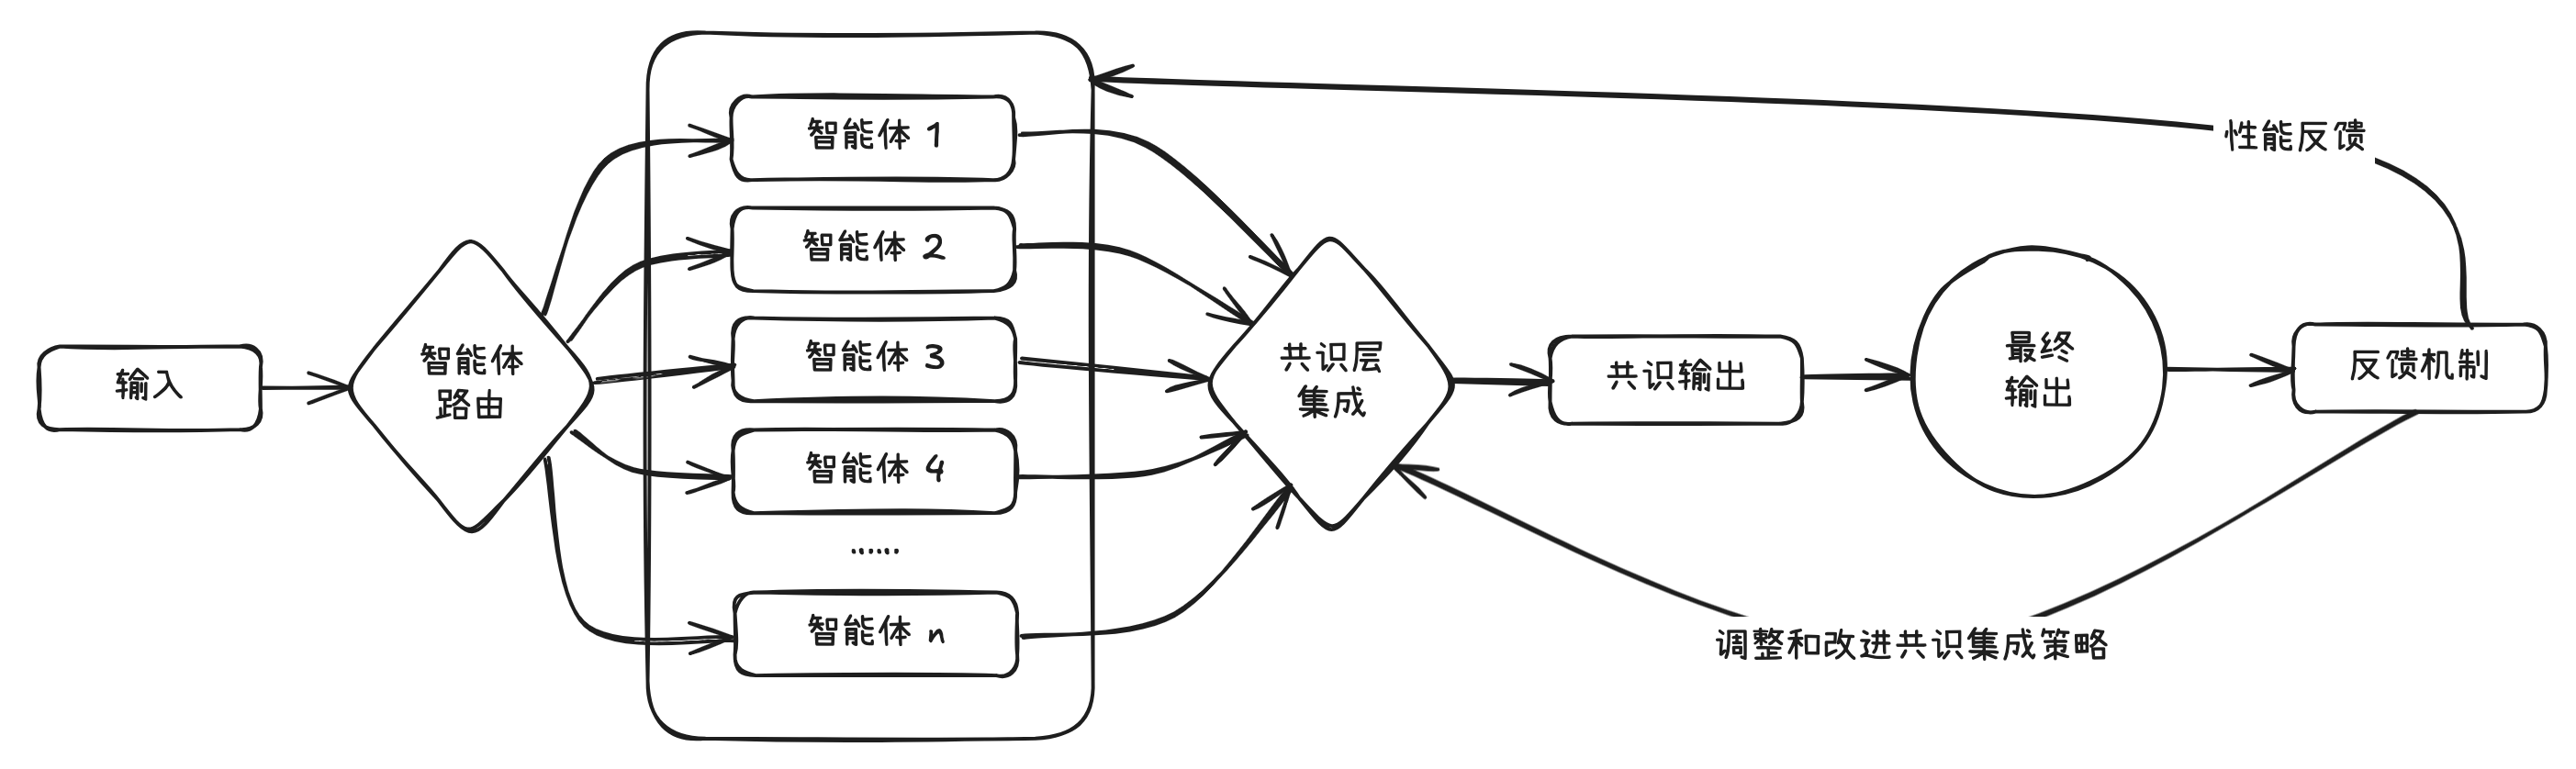

In [1]:
# -*- coding: utf-8 -*-
"""
# 智能体系统流程演示

本 Jupyter Notebook 演示了一个多智能体协同处理数据并进行反馈优化的系统流程。
该流程对应了图片中的结构，模拟了数据输入、智能体路由、智能体处理、共识层集成、
反馈机制等环节。

"""

import numpy as np
import random
from typing import List, Callable

# --- 1. 数据输入 ---
def generate_input_data():
    """
    生成模拟的输入数据，这里使用简单的随机数作为示例
    """
    return random.random() # 生成 0 到 1 之间的随机浮点数

# --- 2. 智能体定义 ---
class SmartAgent:
    def __init__(self, name: str, processing_function: Callable):
        """
        初始化智能体
        Args:
            name: 智能体名称
            processing_function: 处理输入数据的函数
        """
        self.name = name
        self.process = processing_function

    def process_data(self, data):
        """
        处理输入数据
        Args:
            data: 输入数据
        Returns:
            处理结果
        """
        return self.process(data)

# --- 3. 智能体路由 ---
def smart_agent_routing(data, agents: List[SmartAgent]):
    """
    智能体路由函数：这里使用简单的随机选择智能体的方法
    Args:
        data: 输入数据
        agents: 所有智能体的列表
    Returns:
        一个字典，键为智能体名称，值为处理结果
    """
    chosen_agents = random.sample(agents, random.randint(1, len(agents))) # 随机选择1到所有智能体
    results = {}
    for agent in chosen_agents:
        results[agent.name] = agent.process_data(data) # 调用智能体处理数据
    return results

# --- 4. 共识层集成 ---
def consensus_integration(agent_results: dict, strategy:str = 'average'):
    """
    共识层集成函数，这里使用平均值或加权平均数作为示例
    Args:
        agent_results: 各个智能体的处理结果字典
        strategy: 集成策略，默认为'average'，可选'weighted_average'
    Returns:
        共识结果
    """

    if strategy == 'average':
        results = list(agent_results.values())
        if results:
            return sum(results) / len(results)
        else:
            return 0

    elif strategy == 'weighted_average':
        weights = np.random.rand(len(agent_results))
        values = np.array(list(agent_results.values()))
        return np.dot(weights / weights.sum(), values)

    else:
        raise ValueError("Unsupported integration strategy")

# --- 5. 反馈机制 ---
def feedback_mechanism(output, expected_output):
    """
    反馈机制，计算输出和期望输出之间的误差
    Args:
        output: 系统输出
        expected_output: 期望输出
    Returns:
        误差值
    """
    return abs(output - expected_output)

def adjust_integration_strategy(error, current_strategy):
    """
    调整共识集成策略, 这里示例使用简单的规则
    Args:
        error: 系统误差
        current_strategy: 当前策略
    Returns:
        调整后的策略
    """
    if error > 0.2:
        if current_strategy == 'average':
           return 'weighted_average'
    return current_strategy #如果误差不大则保持当前策略

# --- 6. 模拟系统运行 ---
def run_system(num_iterations: int = 10, agents: List[SmartAgent] = None, initial_strategy='average'):
    """
    模拟系统运行
    Args:
        num_iterations: 迭代次数
        agents: 所有智能体的列表
        initial_strategy: 初始共识集成策略
    """
    if agents is None:
        agents = create_default_agents()  # 如果没有传递，则创建默认智能体
    strategy = initial_strategy
    errors = [] # 用于记录每次迭代的误差
    for i in range(num_iterations):
        input_data = generate_input_data()
        print(f"\nIteration {i+1}: Input Data = {input_data:.2f}")
        agent_results = smart_agent_routing(input_data, agents) # 智能体路由
        print("  Agent Results:", agent_results)
        output = consensus_integration(agent_results, strategy)  # 共识集成
        print(f"  Consensus Output: {output:.2f}")
        expected_output = input_data * 2  # 示例，期望输出是输入的两倍
        error = feedback_mechanism(output, expected_output)  # 反馈机制
        print(f"  Error: {error:.2f}")
        errors.append(error)
        strategy = adjust_integration_strategy(error, strategy) # 调整策略
        print(f"  Updated Strategy: {strategy}")

    print('\nErrors per iteration:', errors)
    print(f"Final strategy: {strategy}")

# --- 7. 定义默认智能体 ---
def create_default_agents():
    """
     创建一组默认智能体
    Returns:
        智能体列表
    """
    agents = [
        SmartAgent("Agent 1", lambda x: x * 1.1),
        SmartAgent("Agent 2", lambda x: x * 0.9),
        SmartAgent("Agent 3", lambda x: x * 1.2),
        SmartAgent("Agent 4", lambda x: x * 0.8),
    ]
    return agents


# --- 主函数 ---
if __name__ == '__main__':
    print("# Start Simulation #\n")
    run_system(num_iterations = 10) # 运行模拟系统

# Start Simulation #


Iteration 1: Input Data = 0.64
  Agent Results: {'Agent 1': 0.7081425234912809, 'Agent 4': 0.5150127443572953, 'Agent 2': 0.5793893374019571, 'Agent 3': 0.7725191165359427}
  Consensus Output: 0.64
  Error: 0.64
  Updated Strategy: weighted_average

Iteration 2: Input Data = 0.47
  Agent Results: {'Agent 4': 0.37839675794540073, 'Agent 3': 0.567595136918101, 'Agent 1': 0.520295542174926}
  Consensus Output: 0.51
  Error: 0.43
  Updated Strategy: weighted_average

Iteration 3: Input Data = 0.21
  Agent Results: {'Agent 2': 0.18924620598973976}
  Consensus Output: 0.19
  Error: 0.23
  Updated Strategy: weighted_average

Iteration 4: Input Data = 0.41
  Agent Results: {'Agent 2': 0.3720555525875513}
  Consensus Output: 0.37
  Error: 0.45
  Updated Strategy: weighted_average

Iteration 5: Input Data = 0.85
  Agent Results: {'Agent 1': 0.9367585309024407}
  Consensus Output: 0.94
  Error: 0.77
  Updated Strategy: weighted_average

Iteration 6: Input Data = 0.05
  Agen

### 多任务微调 Fine-Tuning LLM's For Multiple Tasks

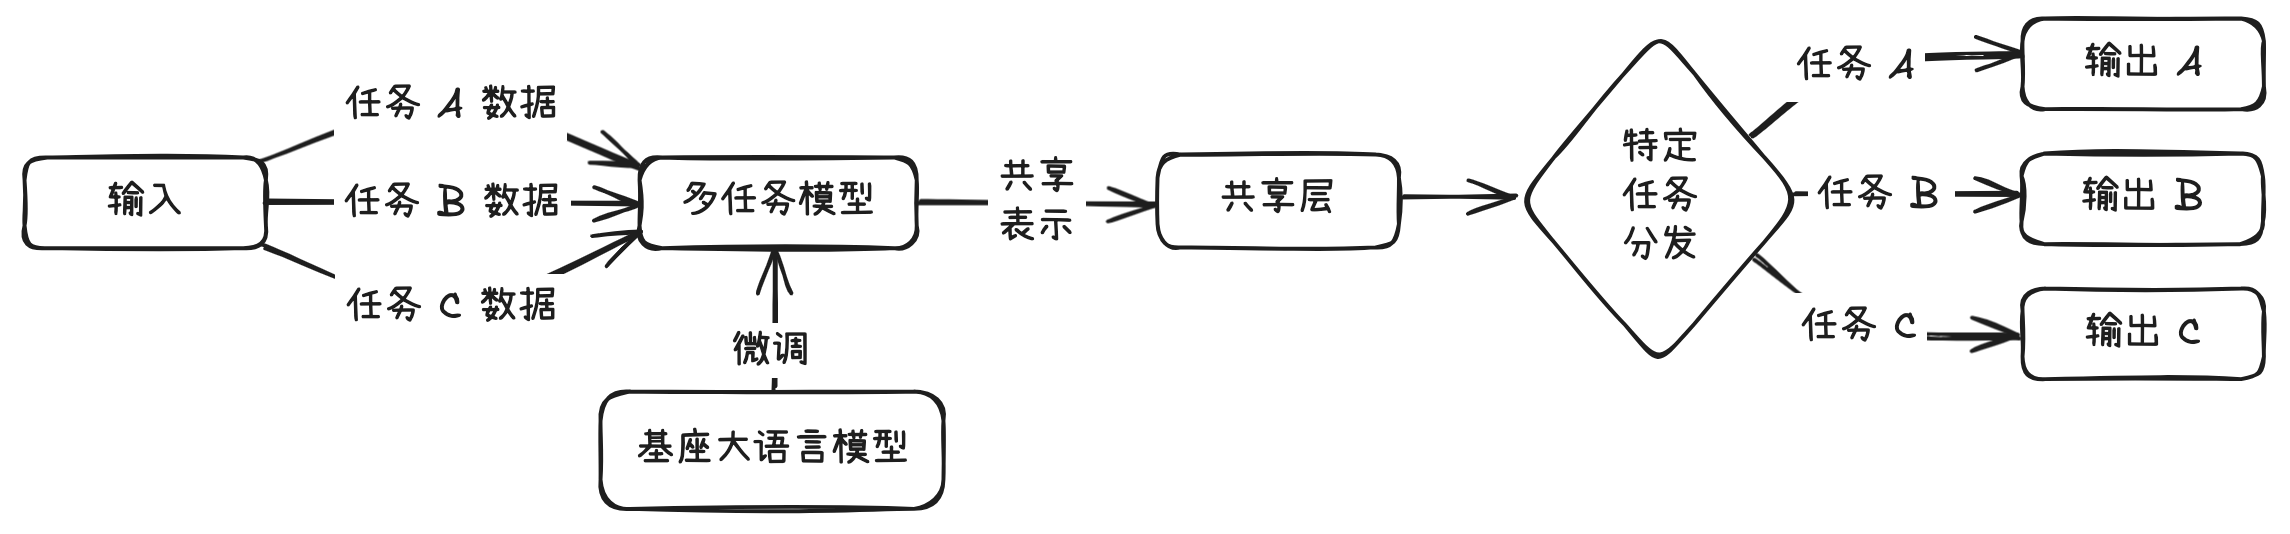

### 模块化组合 Modular Monolith LLM Approach With Composability

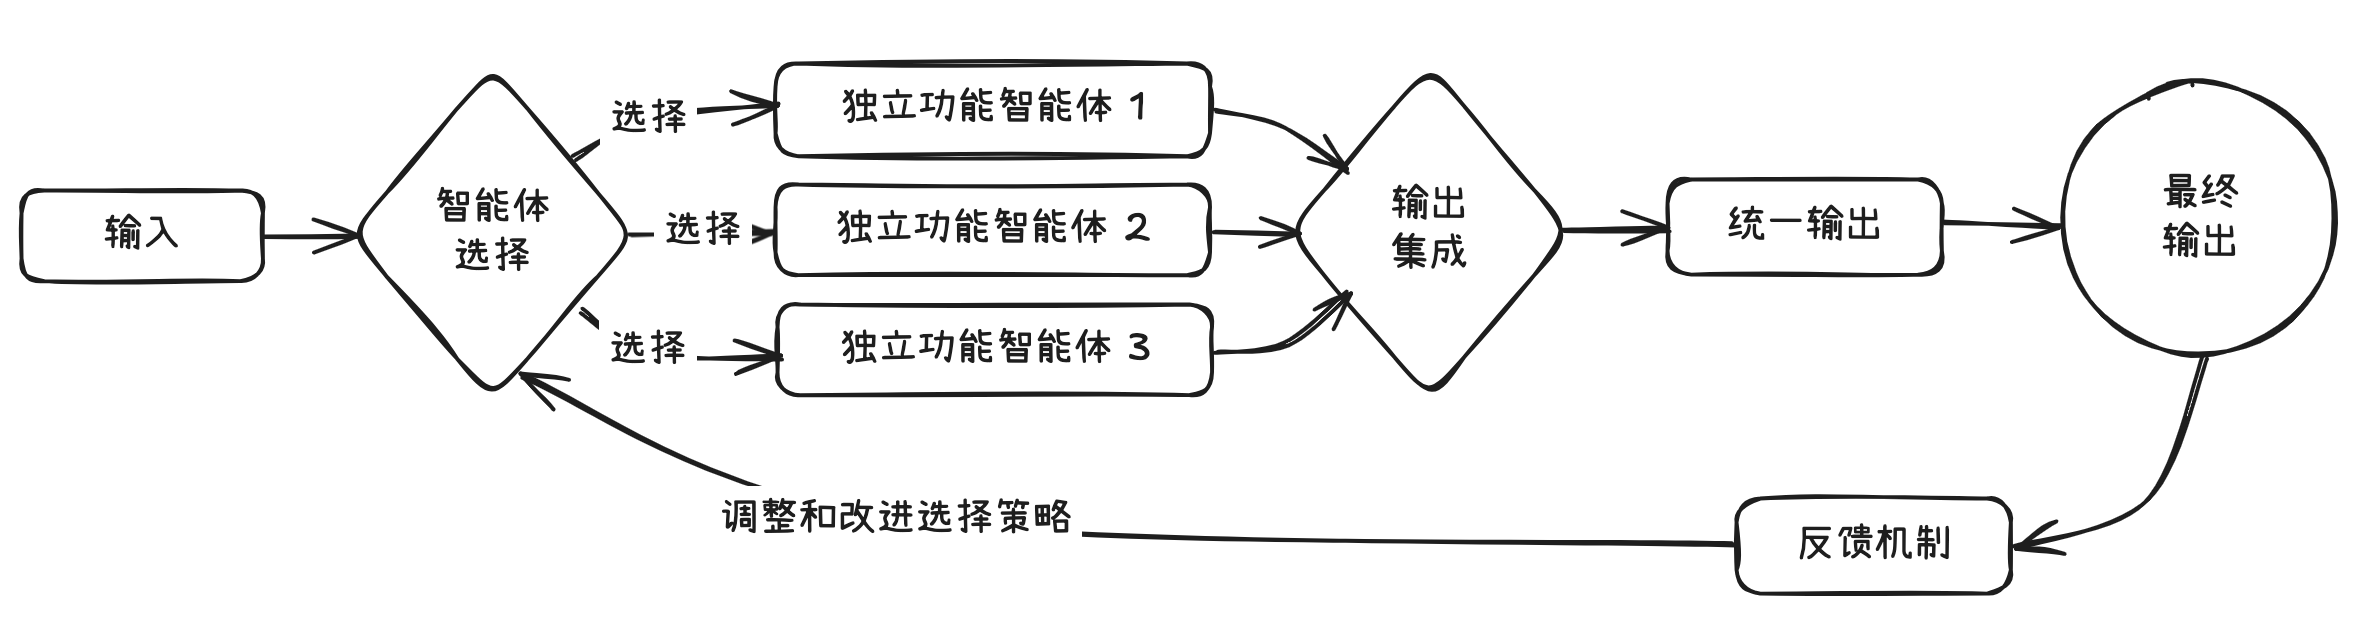

### 知识库驱动 Utilizing Knowledge Graphs with LLM's

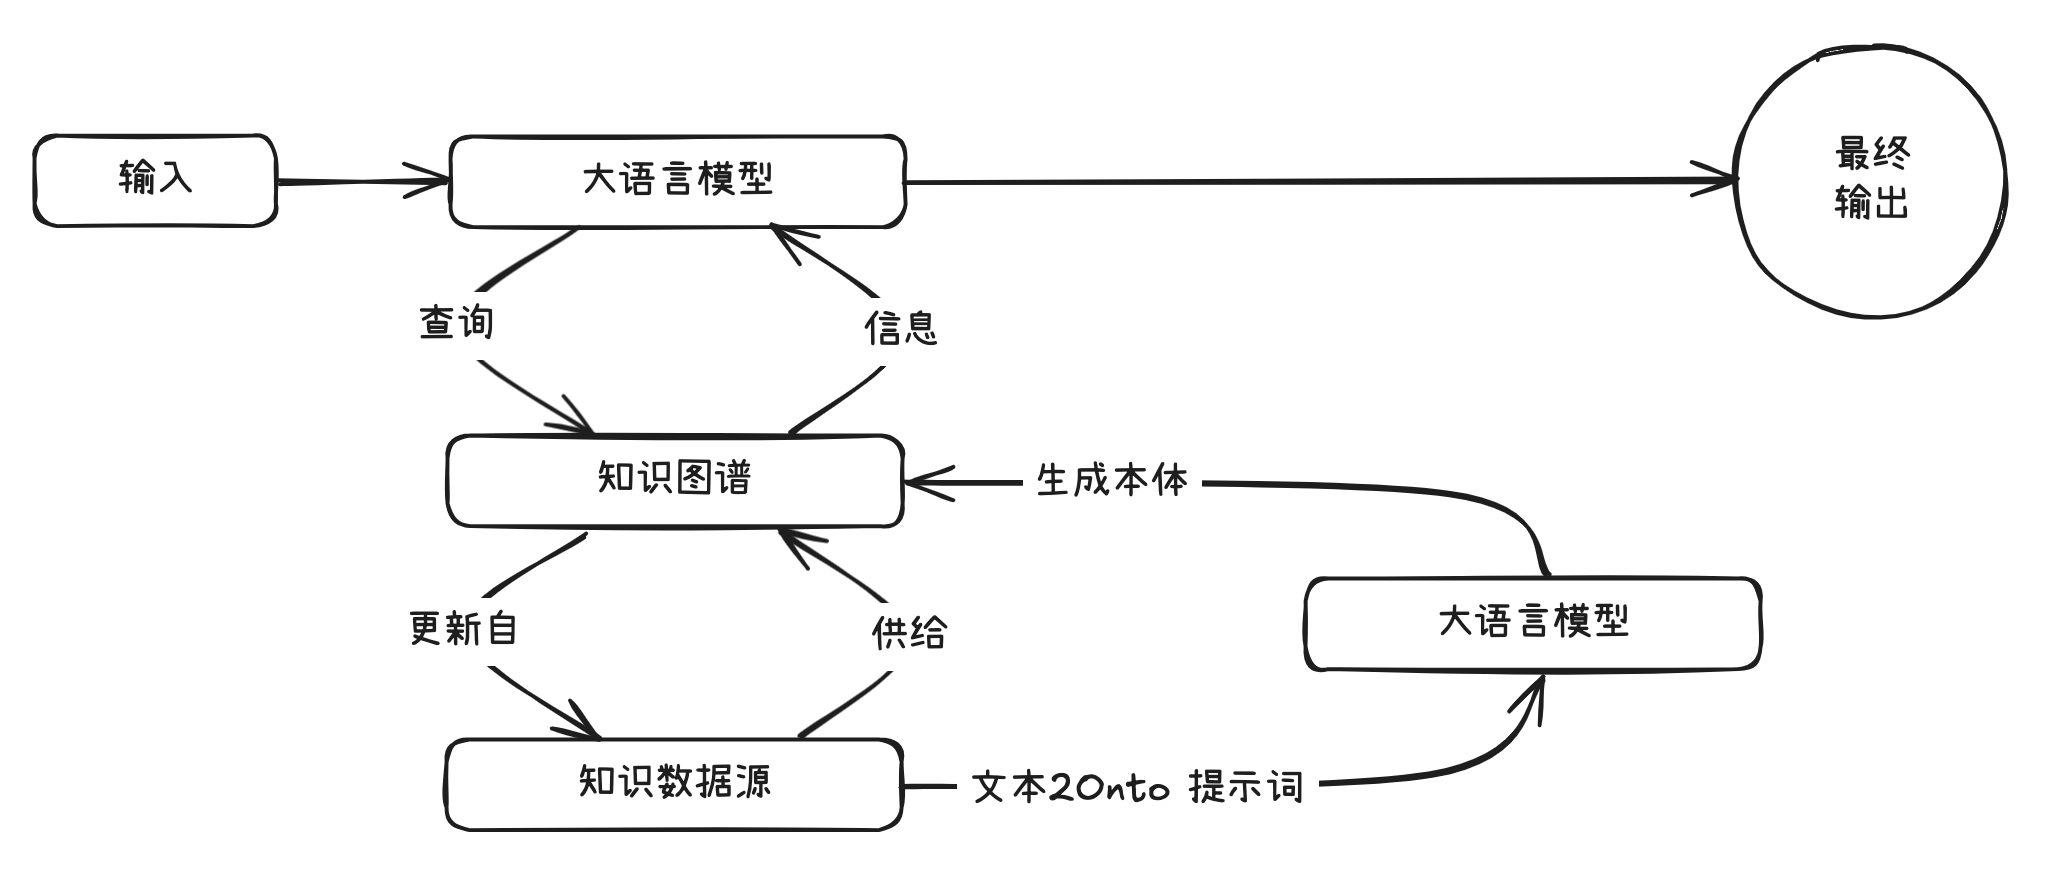

### 双模评估 Red & Blue Team Dual-Model Evaluation

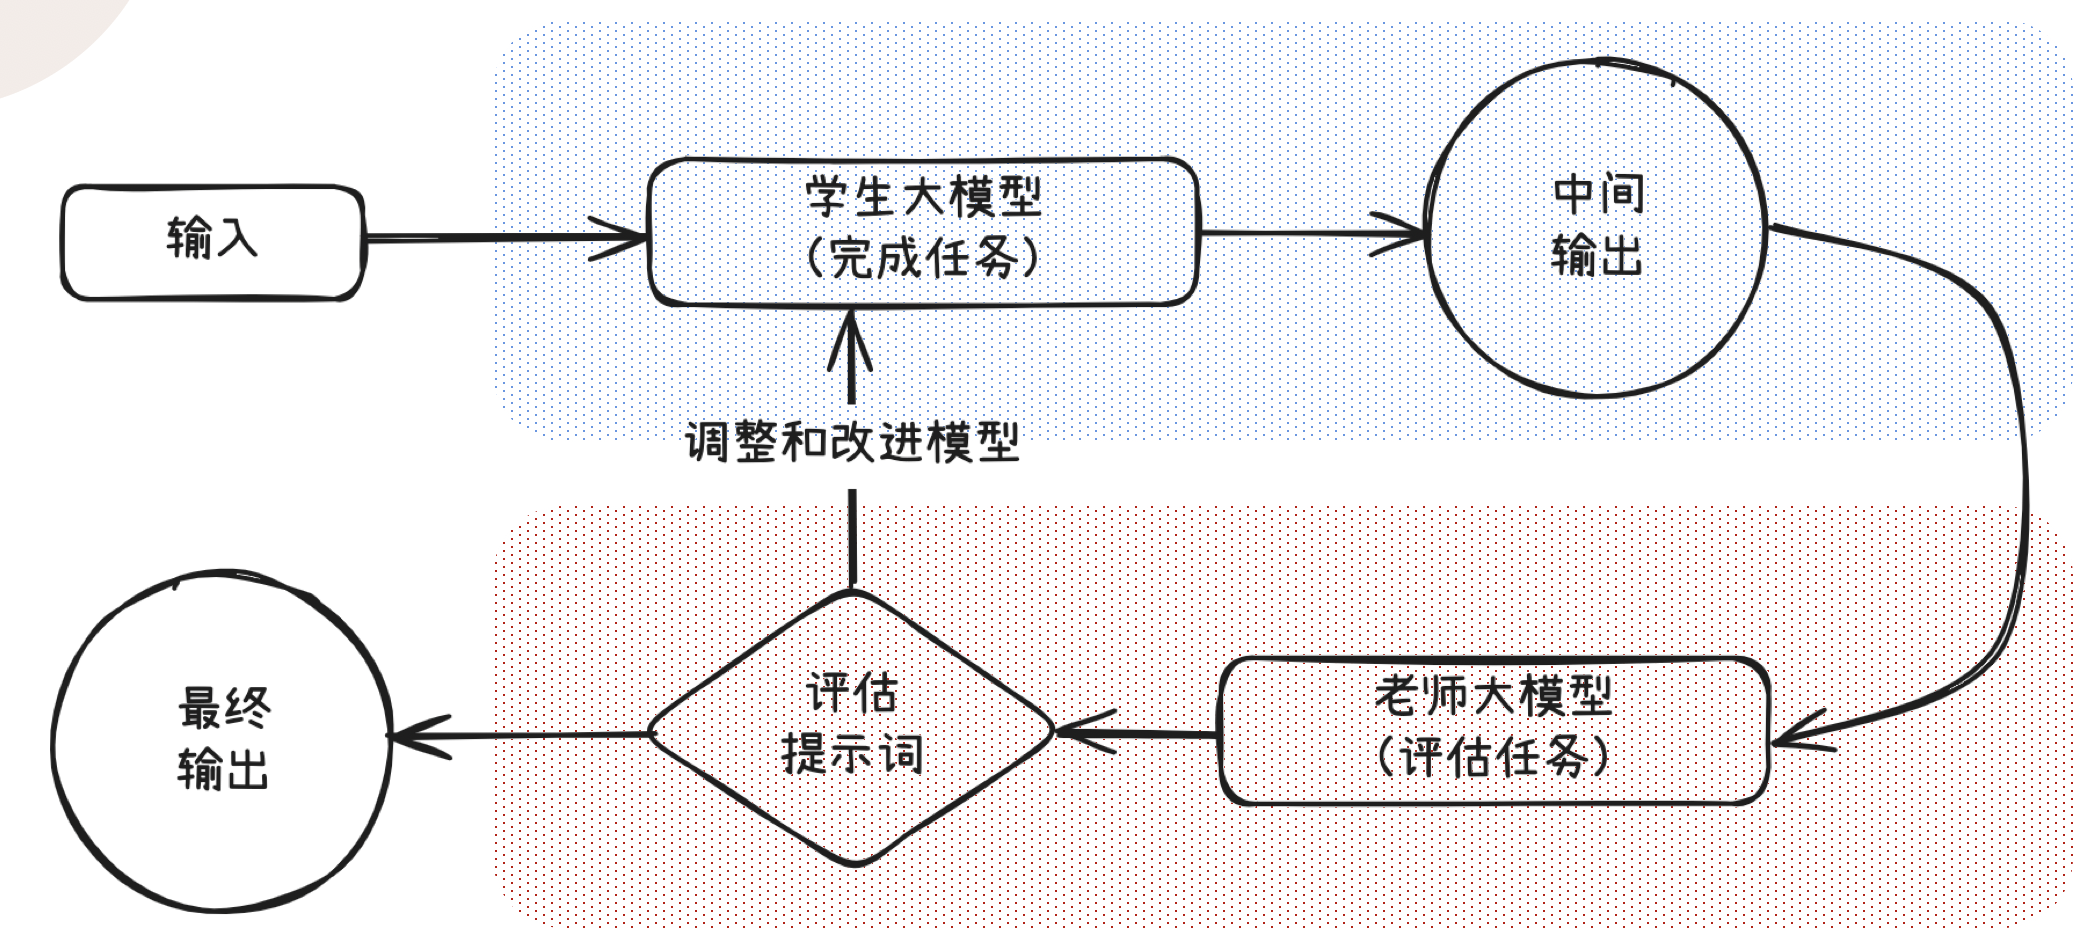